In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
data_import = pd.read_csv('../Data/LT_DU_data_for_ML_All_variations.csv') # All variations of categorical and numeric transformations
data_import.columns

Index(['lpk', 'hourly_rate', 'experience', 'weeks', 'vacation',
       'esize_class_ord', 'esize_class_orig', 'esize_class_oh_1_49',
       'esize_class_oh_50_249', 'esize_class_oh_GT_250', 'gender_orig',
       'gender_M', 'age_class_ord', 'age_class_orig', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+', 'education_ord', 'education_orig',
       'education_oh_G1', 'education_oh_G2', 'education_oh_G3',
       'education_oh_G4', 'outlier', 'nace_orig', 'nace_B', 'nace_C', 'nace_D',
       'nace_E', 'nace_F', 'nace_G', 'nace_H', 'nace_I', 'nace_J', 'nace_K',
       'nace_L', 'nace_M', 'nace_N', 'nace_O', 'nace_P', 'nace_Q', 'nace_R',
       'nace_S', 'hourly_rate_norm', 'experience_sc', 'weeks_sc',
       'vacation_sc'],
      dtype='object')

# Data selection and filtering

## Parameters

In [6]:
#Normalize 'hourly_rate' ('no'/'yes')?
normalize = 'no'
#Select lpk level. Valid options: '1' (0), '2' (00), '3' (000).
lpk_level = 3
#Remove outliers ('no'/'yes')?
remove_outliers = 'yes'
#Remove upper boundary ('no'/'yes')?
upper_boundary = 15
remove_above_boundary = 'no'
#Remove below minimal wage ('no'/'yes')?
lower_boundary = 2.45
remove_below_boundary = 'no'
#Use scaled numeric features ('no'/'yes')?
use_numeric = 'no'
#Use ordinary or one hot encoding for 'esize_class_ord', 'age_class_ord', 'education_ord'?
#'no' use One Hot, 'yes' use ordinary
use_ordinary = 'no'
#Use nace One Hot ('no'/'yes')?
nace_one_hot = 'yes'

## Selection and filtering

In [7]:
data=data_import.copy()

#Normalize 'hourly_rate' ('no'/'yes')?
if normalize == 'no':
    data.drop(columns=['hourly_rate_norm'], inplace=True)
    target='hourly_rate'
else:
    data.drop(columns=['hourly_rate'], inplace=True)
    target='hourly_rate_norm'

print(f'Target label is "{target}"')

#One Hot encoding for selected lpk level
lpk_level_label = 'lpk_'+str(lpk_level)
data[lpk_level_label] = data['lpk'] // (10**(3-lpk_level))
data = pd.get_dummies(data, prefix='lpk' ,columns=[lpk_level_label])
print(f'LPK encoded using {lpk_level_label}')

#Outliers
if remove_outliers == 'yes':
    data=data.query('outlier==False')
    print('Outliers removed')
else:
    print('Outliers retained')

# Include upper boundary?
if remove_above_boundary == 'yes':
    data=data.query('hourly_rate <= @upper_boundary')
    print('Target values above boundary are removed')
else:
    print('All records above boundary retained')

#Remove below minimal wage?
if remove_below_boundary == 'yes':
    data=data.query('hourly_rate >= @lower_boundary')
    print('All records below minimal wage are removed')
else:
    print('All records below minimal wage retained')

#Use scaled numeric features?
if use_numeric == 'no':
    data.drop(columns=['experience_sc', 'weeks_sc', 'vacation_sc'], inplace=True)
    print('Scaled numeric features are removed')
else:
    print('Scaled numeric features are used')

#Use ordinary or one hot encoding for 'esize_class', 'age_class', 'education'?
if use_ordinary == 'yes':
    data.drop(columns=data.columns[data.columns.str.contains('_oh_')], inplace= True)
    print('Ordinari encoding for esize_class, age_class, education used')
else:
    data.drop(columns=data.columns[data.columns.str.contains('_ord')], inplace= True)
    print('One hot encoding for esize_class, age_class, education used')

#Use nace One Hot ('no'/'yes')?
if nace_one_hot == 'no':
    data.drop(columns=data.columns[data.columns.str.contains('nace_')], inplace= True)
    print('Original nace values')
else:
    data.drop(columns='nace_orig', inplace= True)
    print('One hot encoding for used nace ')

#Remove meta columns (not used in ML development)
remove_col = ['lpk', 'outlier',
             'esize_class_orig','gender_orig','age_class_orig','education_orig',
             'experience', 'weeks', 'vacation']
data.drop(columns=remove_col, inplace=True )



Target label is "hourly_rate"
LPK encoded using lpk_3
Outliers removed
All records above boundary retained
All records below minimal wage retained
Scaled numeric features are removed
One hot encoding for esize_class, age_class, education used
One hot encoding for used nace 


In [8]:
data.columns

Index(['hourly_rate', 'esize_class_oh_1_49', 'esize_class_oh_50_249',
       'esize_class_oh_GT_250', 'gender_M', 'age_class_oh_14-29',
       'age_class_oh_30-39', 'age_class_oh_40-49', 'age_class_oh_50-59',
       'age_class_oh_60+',
       ...
       'lpk_835', 'lpk_911', 'lpk_912', 'lpk_921', 'lpk_931', 'lpk_932',
       'lpk_933', 'lpk_941', 'lpk_961', 'lpk_962'],
      dtype='object', length=145)

# Prepare X and y

In [9]:
y = data[target]
X = data.drop(columns=target)
y.shape , X.shape

((35170,), (35170, 144))

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((28136,), (7034,))

In [11]:
y_train_mean = np.mean(y_train)

# Model and predictions

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf
import keras_tuner as kt

In [13]:
def model_builder(hp):
  model = tf.keras.Sequential()
  hp_units = hp.Int('units', min_value=16, max_value=64, step=4)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(units=1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()]
                )
  return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='tf_turner',
                     project_name='LTDU_tf_hp')

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [18]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 23s]
val_loss: 3.712616443634033

Best val_loss So Far: 3.672314405441284
Total elapsed time: 00h 04m 50s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 36 and the optimal learning rate for the optimizer
is 0.001.



In [33]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,callbacks=[stop_early] )

Epoch 1/50
704/704 [==============================] - 2s 3ms/step - loss: 8.8986 - root_mean_squared_error: 2.9831 - val_loss: 4.5047 - val_root_mean_squared_error: 2.1224
Epoch 2/50
704/704 [==============================] - 2s 3ms/step - loss: 4.2625 - root_mean_squared_error: 2.0646 - val_loss: 4.0960 - val_root_mean_squared_error: 2.0239
Epoch 3/50
704/704 [==============================] - 2s 3ms/step - loss: 3.9919 - root_mean_squared_error: 1.9980 - val_loss: 3.8847 - val_root_mean_squared_error: 1.9710
Epoch 4/50
704/704 [==============================] - 2s 3ms/step - loss: 3.8401 - root_mean_squared_error: 1.9596 - val_loss: 3.7938 - val_root_mean_squared_error: 1.9478
Epoch 5/50
704/704 [==============================] - 2s 3ms/step - loss: 3.7339 - root_mean_squared_error: 1.9323 - val_loss: 3.7387 - val_root_mean_squared_error: 1.9336
Epoch 6/50
704/704 [==============================] - 2s 3ms/step - loss: 3.6626 - root_mean_squared_error: 1.9138 - val_loss: 3.6827 - val_

In [34]:

val_acc_per_epoch = history.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 14


Minimum validation root_mean_squared_error: 1.8974159955978394


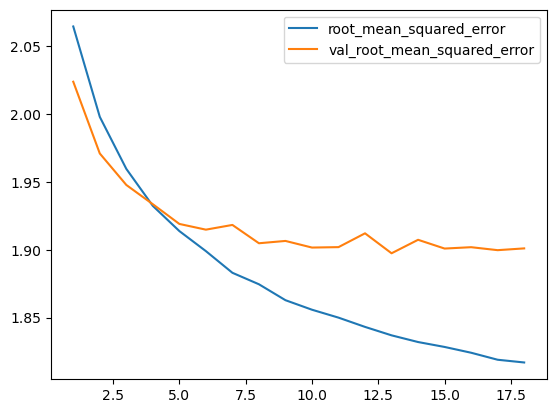

In [35]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation root_mean_squared_error: {}".format(history_df['val_root_mean_squared_error'].min()))

In [42]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/14
704/704 [==============================] - 2s 3ms/step - loss: 7.3529 - root_mean_squared_error: 2.7116 - val_loss: 4.3124 - val_root_mean_squared_error: 2.0766
Epoch 2/14
704/704 [==============================] - 2s 3ms/step - loss: 4.1639 - root_mean_squared_error: 2.0406 - val_loss: 4.0410 - val_root_mean_squared_error: 2.0102
Epoch 3/14
704/704 [==============================] - 2s 3ms/step - loss: 3.9776 - root_mean_squared_error: 1.9944 - val_loss: 3.9060 - val_root_mean_squared_error: 1.9764
Epoch 4/14
704/704 [==============================] - 2s 3ms/step - loss: 3.8562 - root_mean_squared_error: 1.9637 - val_loss: 3.8118 - val_root_mean_squared_error: 1.9524
Epoch 5/14
704/704 [==============================] - 2s 3ms/step - loss: 3.7662 - root_mean_squared_error: 1.9407 - val_loss: 3.7689 - val_root_mean_squared_error: 1.9414
Epoch 6/14
704/704 [==============================] - 2s 3ms/step - loss: 3.6974 - root_mean_squared_error: 1.9229 - val_loss: 3.7352 - val_

In [43]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

220/220 [==============================] - 1s 2ms/step - loss: 3.5842 - root_mean_squared_error: 1.8932
[test loss, test accuracy]: [3.5841596126556396, 1.8931876420974731]


In [44]:

y_train_pred = hypermodel.predict(X_train).flatten()
y_test_pred = hypermodel.predict(X_test).flatten()


220/220 [==============================] - 0s 977us/step


In [45]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.846  R2= 0.562
Test: RMSE= 1.893  R2= 0.524


In [46]:
residuals_test=y_test_pred-y_test
r_residuals_test=(residuals_test)/y_test*100

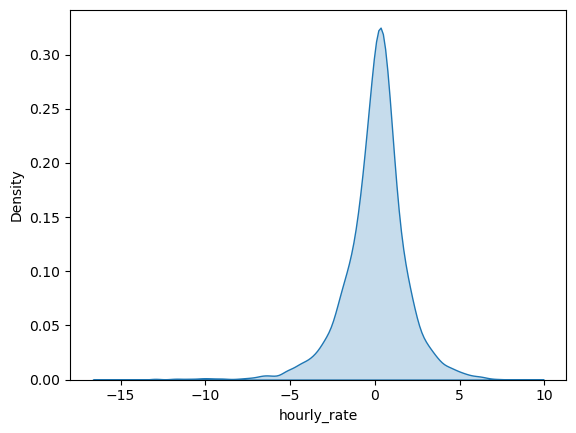

In [47]:
sns.kdeplot(residuals_test, fill=True);

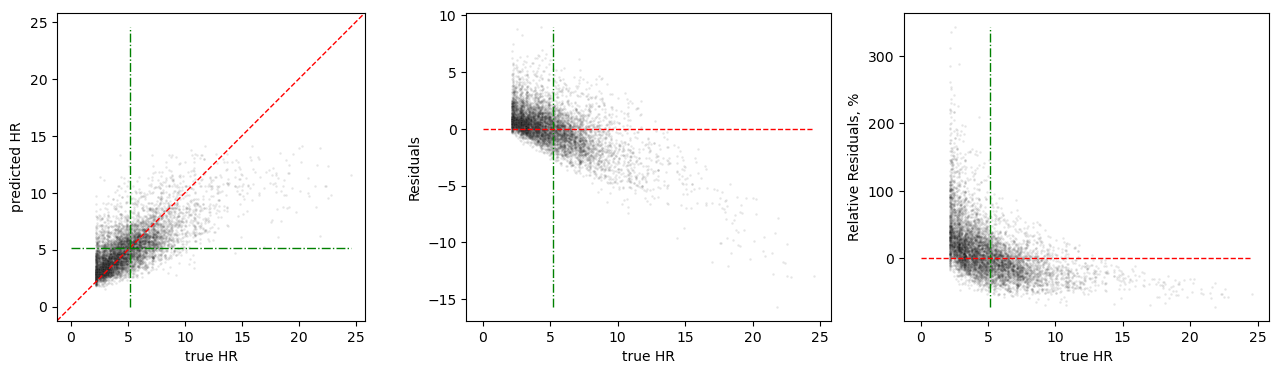

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.scatterplot(ax=ax[0], x=y_test, y=y_test_pred,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[0],  x=y_test, y=y_test_pred, alpha=0.5 )
ax[0].set_xlabel('true HR')
ax[0].set_ylabel('predicted HR')
ax[0].set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax[0].plot((0,1), (0, 1), transform=ax[0].transAxes, linestyle='--', color='r', lw=1)
ax[0].vlines(ymin=0, ymax=max(y_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[0].hlines(xmin=0, xmax=max(y_test) , y=y_train_mean, linestyle='-.', color='g', lw=1)

sns.scatterplot(ax=ax[1],  x=y_test, y=residuals_test,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[1], x=y_test, y=residuals_test, alpha=0.5 )
ax[1].set_xlabel('true HR')
ax[1].set_ylabel('Residuals')
ax[1].vlines(ymin=min(residuals_test), ymax=max(residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[1].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1)

sns.scatterplot(ax=ax[2],  x=y_test, y=r_residuals_test,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[2],  x=y_test, y=r_residuals_test, alpha=0.5 )
ax[2].set_xlabel('true HR')
ax[2].set_ylabel('Relative Residuals, %')
ax[2].vlines(ymin=min(r_residuals_test), ymax=max(r_residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[2].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1);